# Load ALpha Pose Skeleton

In [14]:
%matplotlib widget


In [15]:
import json 
  
# Opening JSON file 
f = open('alphapose-results.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  

# Closing file 
f.close() 

In [16]:
data[0]

{'image_id': '59.jpg',
 'category_id': 1,
 'keypoints': [1307.9923095703125,
  172.1859893798828,
  0.42333152890205383,
  1384.959716796875,
  107.05973815917969,
  0.8450673818588257,
  1219.183837890625,
  95.21861267089844,
  0.8216601014137268,
  1485.609375,
  107.05973815917969,
  0.8520224690437317,
  1148.136962890625,
  59.695194244384766,
  0.03165171667933464,
  1538.89453125,
  409.0086975097656,
  0.14754869043827057,
  1053.407958984375,
  189.9477081298828,
  0.22390754520893097,
  1532.973876953125,
  491.8966369628906,
  0.008370662108063698,
  994.2023315429688,
  266.9150695800781,
  0.30464670062065125,
  1071.169677734375,
  450.4526672363281,
  0.009295416064560413,
  1041.5667724609375,
  503.7377624511719,
  0.50244140625,
  1296.151123046875,
  260.9945068359375,
  0.008964317850768566,
  1177.7398681640625,
  545.1817016601562,
  0.03766326978802681,
  1272.468994140625,
  551.1023559570312,
  0.017207080498337746,
  1213.26318359375,
  580.7051391601562,
  0

In [17]:
len(data)

156

In [18]:
len(data[0]['keypoints'])

51

In [19]:
data

[{'image_id': '59.jpg',
  'category_id': 1,
  'keypoints': [1307.9923095703125,
   172.1859893798828,
   0.42333152890205383,
   1384.959716796875,
   107.05973815917969,
   0.8450673818588257,
   1219.183837890625,
   95.21861267089844,
   0.8216601014137268,
   1485.609375,
   107.05973815917969,
   0.8520224690437317,
   1148.136962890625,
   59.695194244384766,
   0.03165171667933464,
   1538.89453125,
   409.0086975097656,
   0.14754869043827057,
   1053.407958984375,
   189.9477081298828,
   0.22390754520893097,
   1532.973876953125,
   491.8966369628906,
   0.008370662108063698,
   994.2023315429688,
   266.9150695800781,
   0.30464670062065125,
   1071.169677734375,
   450.4526672363281,
   0.009295416064560413,
   1041.5667724609375,
   503.7377624511719,
   0.50244140625,
   1296.151123046875,
   260.9945068359375,
   0.008964317850768566,
   1177.7398681640625,
   545.1817016601562,
   0.03766326978802681,
   1272.468994140625,
   551.1023559570312,
   0.017207080498337746,


In [20]:
import torch
import re
import collections
from torch._six import string_classes, int_classes
import cv2
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn as nn

def euclidean_dist(a, b):
      # This function calculates the euclidean distance between 2 point in 2-D coordinates
      # if one of two points is (0,0), dist = 0
      # a, b: input array with dimension: m, 2
      # m: number of samples
      # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0
    

def data_converter(data):
    data=data['keypoints']
    keypoints=[]
    kp_score=[]
    for a in range (0,len(data)):
        keypoint=[]
        score=[]
        if ((a+3)%3==0):
            keypoint=[data[a],data[a+1]]
            keypoints.append(keypoint)
        elif((a+1)%3==0):
            score=[data[a]]
            kp_score.append(score)

    result_dict={}
    result_dict['keypoints']=torch.FloatTensor(keypoints)
    result_dict['kp_score']=torch.FloatTensor(kp_score)
    return result_dict
    
def vis_frame_fast(data, format='coco'):
    '''
    frame: frame image
    im_res: im_res of predictions
    format: coco or mpii

    return rendered image
    '''
    
    data=data_converter(data)
    
    height=720
    width=1280
    blank_image = np.zeros((height,width,3), np.uint8)

    if format == 'coco':
        l_pair = [
            (0, 1), (0, 2), (1, 3), (2, 4),  # Head
            (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
            (17, 11), (17, 12),  # Body
            (11, 13), (12, 14), (13, 15), (14, 16)
        ]
        p_color = [(0, 255, 255), (0, 191, 255),(0, 255, 102),(0, 77, 255), (0, 255, 0), #Nose, LEye, REye, LEar, REar
                    (77,255,255), (77, 255, 204), (77,204,255), (191, 255, 77), (77,191,255), (191, 255, 77), #LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
                    (204,77,255), (77,255,204), (191,77,255), (77,255,191), (127,77,255), (77,255,127), (0, 255, 255)] #LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
        line_color = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50), 
                    (77,255,222), (77,196,255), (77,135,255), (191,255,77), (77,255,77), 
                    (77,222,255), (255,156,127), 
                    (0,127,255), (255,127,77), (0,77,255), (255,77,36)]
    elif format == 'mpii':
        l_pair = [
            (8, 9), (11, 12), (11, 10), (2, 1), (1, 0),
            (13, 14), (14, 15), (3, 4), (4, 5),
            (8, 7), (7, 6), (6, 2), (6, 3), (8, 12), (8, 13)
        ]
        p_color = [PURPLE, BLUE, BLUE, RED, RED, BLUE, BLUE, RED, RED, PURPLE, PURPLE, PURPLE, RED, RED,BLUE,BLUE]
    elif format =='human36':
        l_pair = [
            (0, 1), (0, 2), (1, 3), (2, 4),  # Head
            (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
            (17, 11), (17, 12),  # Body
            (11, 13), (12, 14), (13, 15), (14, 16)
        ]
        p_color = [(0, 255, 255), (0, 191, 255),(0, 255, 102),(0, 77, 255), (0, 255, 0), #Nose, LEye, REye, LEar, REar
                    (77,255,255), (77, 255, 204), (77,204,255), (191, 255, 77), (77,191,255), (191, 255, 77), #LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
                    (204,77,255), (77,255,204), (191,77,255), (77,255,191), (127,77,255), (77,255,127), (0, 255, 255)] #LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
        line_color = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50), 
                    (77,255,222), (77,196,255), (77,135,255), (191,255,77), (77,255,77), 
                    (77,222,255), (255,156,127), 
                    (0,127,255), (255,127,77), (0,77,255), (255,77,36)]
    else:
        NotImplementedError


    part_line = {}
    kp_preds = data['keypoints']
    kp_scores = data['kp_score']
    kp_preds = torch.cat((kp_preds, torch.unsqueeze((kp_preds[5,:]+kp_preds[6,:])/2,0)))
    kp_scores = torch.cat((kp_scores, torch.unsqueeze((kp_scores[5,:]+kp_scores[6,:])/2,0)))
    # Draw keypoints
    for n in range(kp_scores.shape[0]):
        if kp_scores[n] <= 0.05:
            continue
        cor_x, cor_y = int(kp_preds[n, 0]), int(kp_preds[n, 1])
        part_line[n] = (cor_x, cor_y)
        cv2.circle(blank_image, (cor_x, cor_y), 4, p_color[n], 3)
    # Draw limbs
    for i, (start_p, end_p) in enumerate(l_pair):
        if start_p in part_line and end_p in part_line:
            start_xy = part_line[start_p]
            end_xy = part_line[end_p]
            cv2.line(blank_image, start_xy, end_xy, line_color[i], 4)
    return blank_image


In [21]:
img=vis_frame_fast(data[500])

IndexError: list index out of range

In [22]:
img[400]

NameError: name 'img' is not defined

In [23]:
plt.imshow(img)

NameError: name 'img' is not defined

# Load Dataset From Human3.6M

# Load Stat File

In [24]:
stat_file='/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/stat_3d.pth.tar'
stat_ = torch.load(stat_file)


In [25]:
stat_['mean'].shape

(96,)

In [26]:
stat_['std'].shape

(96,)

In [27]:
stat_['dim_use']

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 75, 76, 77, 78, 79, 80, 81, 82, 83])

In [28]:
stat_

{'mean': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.55652589e-01,
        -7.11960573e+00, -9.81433058e-01, -5.65463051e+00,  3.19636009e+02,
         7.19329269e+01, -1.01705840e+01,  6.91147892e+02,  1.55352986e+02,
        -1.15560633e+01,  7.42149725e+02,  1.66477287e+02, -1.18447102e+01,
         7.36763064e+02,  1.65182437e+02,  2.55651315e-01,  7.11954604e+00,
         9.81423860e-01, -5.09729780e+00,  3.27040413e+02,  7.22258095e+01,
        -9.99656606e+00,  7.08277383e+02,  1.58016408e+02, -1.12642400e+01,
         7.48636864e+02,  1.66665977e+02, -1.14090840e+01,  7.36435064e+02,
         1.63713810e+02,  1.21660845e-03, -8.60110629e-02, -1.93000576e-02,
         2.90583676e+00, -2.11363307e+02, -4.74210915e+01,  5.67537804e+00,
        -4.35088906e+02, -9.76974016e+01,  5.93884964e+00, -4.91891970e+02,
        -1.10666618e+02,  7.37352083e+00, -5.83948619e+02, -1.31171400e+02,
         5.67537804e+00, -4.35088906e+02, -9.76974016e+01,  5.41920653e+00,
    

## Load Dataset pth file

In [29]:
train_inp, train_out, test_inp, test_out = [], [], [], []
train_meta, test_meta = [], []

In [30]:
train_2d_file = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/train_2d.pth.tar'
train_3d_file = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/train_3d.pth.tar'


In [31]:
train_2d = torch.load(train_2d_file)
train_3d = torch.load(train_3d_file)


In [32]:
for k2d in train_2d.keys():
    (sub, act, fname) = k2d
    print(act)
    k3d = k2d
    k3d = (sub, act, fname[:-3]) if fname.endswith('-sh') else k3d
    num_f, _ = train_2d[k2d].shape
    assert train_3d[k3d].shape[0] == train_2d[k2d].shape[0], '(training) 3d & 2d shape not matched'
    for i in range(num_f):
        train_inp.append(train_2d[k2d][i])
        train_out.append(train_3d[k3d][i])


Directions
Directions
Directions
Directions
Directions
Directions
Directions
Directions
Discussion
Discussion
Discussion
Discussion
Discussion
Discussion
Discussion
Discussion
Eating
Eating
Eating
Eating
Eating
Eating
Eating
Eating
Greeting
Greeting
Greeting
Greeting
Greeting
Greeting
Greeting
Greeting
Phoning
Phoning
Phoning
Phoning
Phoning
Phoning
Phoning
Phoning
Photo
Photo
Photo
Photo
Photo
Photo
Photo
Photo
Posing
Posing
Posing
Posing
Posing
Posing
Posing
Posing
Purchases
Purchases
Purchases
Purchases
Purchases
Purchases
Purchases
Purchases
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
SittingDown
SittingDown
SittingDown
SittingDown
SittingDown
SittingDown
SittingDown
SittingDown
Smoking
Smoking
Smoking
Smoking
Smoking
Smoking
Smoking
Smoking
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
WalkDog
WalkDog
WalkDog
WalkDog
WalkDog
WalkDog
WalkDog
WalkDog
WalkTogether
WalkTogether
WalkTogether
WalkTogether
WalkTogether
WalkTogether
WalkTogether
WalkT

In [33]:
k2d

(8, 'Walking', 'Walking.60457274.h5')

In [34]:
train_2d[k2d].shape

(3695, 32)

In [35]:
train_inp[0].shape

(32,)

In [36]:
inputs1 = torch.from_numpy(train_inp[0]).float()

In [37]:
inputs1.shape

torch.Size([32])

In [38]:
inputs1

tensor([-0.5421,  0.3977, -0.2589,  0.4643, -0.4268,  0.7369, -0.1919,  0.8265,
        -0.8474,  0.3264, -0.7130,  0.8766, -0.5754,  1.0041, -0.4103,  0.3898,
        -0.4773,  0.3004, -0.4337,  0.1910, -0.7577,  0.4046, -0.9666,  0.5337,
        -1.1160,  0.7342, -0.2088,  0.3555, -0.0908,  0.5050, -0.1309,  0.8436])

In [39]:
train_2d.keys()

dict_keys([(1, 'Directions', 'Directions 1.54138969.h5'), (1, 'Directions', 'Directions 1.55011271.h5'), (1, 'Directions', 'Directions 1.58860488.h5'), (1, 'Directions', 'Directions 1.60457274.h5'), (1, 'Directions', 'Directions.54138969.h5'), (1, 'Directions', 'Directions.55011271.h5'), (1, 'Directions', 'Directions.58860488.h5'), (1, 'Directions', 'Directions.60457274.h5'), (1, 'Discussion', 'Discussion 1.54138969.h5'), (1, 'Discussion', 'Discussion 1.55011271.h5'), (1, 'Discussion', 'Discussion 1.58860488.h5'), (1, 'Discussion', 'Discussion 1.60457274.h5'), (1, 'Discussion', 'Discussion.54138969.h5'), (1, 'Discussion', 'Discussion.55011271.h5'), (1, 'Discussion', 'Discussion.58860488.h5'), (1, 'Discussion', 'Discussion.60457274.h5'), (1, 'Eating', 'Eating 2.54138969.h5'), (1, 'Eating', 'Eating 2.55011271.h5'), (1, 'Eating', 'Eating 2.58860488.h5'), (1, 'Eating', 'Eating 2.60457274.h5'), (1, 'Eating', 'Eating.54138969.h5'), (1, 'Eating', 'Eating.55011271.h5'), (1, 'Eating', 'Eating.5

In [40]:
train_2d[(1, 'Eating', 'Eating 2.54138969.h5')].shape

(2357, 32)

# Load Dataset Using Dataset Loader

In [41]:
from src.datasets.human36m import Human36M
from torch.utils.data import DataLoader
import src.misc as misc
import src.data_process as data_process
from torch.autograd import Variable


actions = misc.define_actions('All')


In [42]:
actions

['Directions',
 'Discussion',
 'Eating',
 'Greeting',
 'Phoning',
 'Photo',
 'Posing',
 'Purchases',
 'Sitting',
 'SittingDown',
 'Smoking',
 'Waiting',
 'WalkDog',
 'Walking',
 'WalkTogether']

In [43]:
train_loader = DataLoader(
    dataset=Human36M(actions=actions, data_path='data/', use_hg=False),
    batch_size=1024,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

test_loader = DataLoader(
    dataset=Human36M(actions=actions, data_path='data/', use_hg=False,is_train=False),
    batch_size=1024,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

In [44]:
test_loader.dataset.test_inp[0].shape #Input 2D

(32,)

In [45]:
test_loader.dataset.test_inp[0].shape

(32,)

In [46]:
test_loader.dataset.test_out[0].shape #Input 2D

(48,)

In [47]:
len(train_loader.dataset.train_inp)

1559752

In [48]:
dataset=Human36M(actions=actions, data_path='data/', use_hg=False),


## Unnormalize Data and Visualize Data

  H36M_NAMES = ['']*32 <br>
  H36M_NAMES[0]  = 'Hip' <br>
  H36M_NAMES[1]  = 'RHip'<br>
  H36M_NAMES[2]  = 'RKnee'<br>
  H36M_NAMES[3]  = 'RFoot'<br>
  H36M_NAMES[4]  = 'RFootTip'<br>
  H36M_NAMES[6]  = 'LHip'<br>
  H36M_NAMES[7]  = 'LKnee'<br>
  H36M_NAMES[8]  = 'LFoot'<br>
  H36M_NAMES[12] = 'Spine'<br>
  H36M_NAMES[13] = 'Thorax'<br>
  H36M_NAMES[14] = 'Neck/Nose'<br>
  H36M_NAMES[15] = 'Head'<br>
  H36M_NAMES[17] = 'LShoulder'<br>
  H36M_NAMES[18] = 'LElbow'<br>
  H36M_NAMES[19] = 'LWrist'<br>
  H36M_NAMES[25] = 'RShoulder'<br>
  H36M_NAMES[26] = 'RElbow'<br>
  H36M_NAMES[27] = 'RWrist'<br>


inps is input 2D
tars is label 3D

Normalized 3D data has shape of [48,] because only 16 join are used.<br>
After already unnormalized, 3D data will have [96,],because it will converted to state when all 32 join used before normalized.<br>
Unnormalized data is necessary for visualization and inference<br>

For calculate error, the dimension that ignored will be removed so in this case it will inference using shape [51,]

## Function to Unnormalize Data

In [49]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import division

import numpy as np


def unNormalizeData(normalized_data, data_mean, data_std, dimensions_to_use):
    T = normalized_data.shape[0]  # Batch size
    D = data_mean.shape[0]  # 96

    orig_data = np.zeros((T, D), dtype=np.float32)

    orig_data[:, dimensions_to_use] = normalized_data

    # Multiply times stdev and add the mean
    stdMat = data_std.reshape((1, D))
    stdMat = np.repeat(stdMat, T, axis=0)
    meanMat = data_mean.reshape((1, D))
    meanMat = np.repeat(meanMat, T, axis=0)
    orig_data = np.multiply(orig_data, stdMat) + meanMat
    return orig_data

In [50]:


for i, (inps, tars) in enumerate(test_loader):
    inputs = Variable(inps.cuda())
    targets = Variable(tars.cuda(non_blocking=True))

    tars = targets
    ins=inputs

    # Normalize 3D
    # Use targets_unnorm for visualization
    targets_unnorm = data_process.unNormalizeData(tars.data.cpu().numpy(), stat_['mean'], stat_['std'], stat_['dim_use'])
    
    # remove dim ignored
    dim_use = np.hstack((np.arange(3), stat_['dim_use']))
    
    targets_use = targets_unnorm[:, dim_use]
    


In [51]:
test_loader.dataset.test_inp[0].shape #This is normalized dataset

(32,)

In [52]:
targets_unnorm[0].shape # This is unnormalized dataset for visualization

(96,)

In [53]:
targets_use[0].shape # This is unnormalized dataset with dim ignored removed for inference

(51,)

## Function for Visualizing

In [54]:
import src.data_utils as data_utils


def show3Dpose(channels, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False): # blue, orange
    """
    Visualize a 3d skeleton

    Args
    channels: 96x1 vector. The pose to plot.
    ax: matplotlib 3d axis to draw on
    lcolor: color for left part of the body
    rcolor: color for right part of the body
    add_labels: whether to add coordinate labels
    Returns
    Nothing. Draws on ax.
    """


    assert channels.size == len(data_utils.H36M_NAMES)*3, "channels should have 96 entries, it has %d instead" % channels.size
    vals = np.reshape( channels, (len(data_utils.H36M_NAMES), -1) )

    I   = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1 # start points
    J   = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1 # end points
    LR  = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

    # Make connection matrix
    for i in np.arange( len(I) ):
        x, y, z = [np.array( [vals[I[i], j], vals[J[i], j]] ) for j in range(3)]
        ax.plot(x, y, z, lw=2, c=lcolor if LR[i] else rcolor)

    RADIUS = 750 # space around the subject
    xroot, yroot, zroot = vals[0,0], vals[0,1], vals[0,2]
    ax.set_xlim3d([-RADIUS+xroot, RADIUS+xroot])
    ax.set_zlim3d([-RADIUS+zroot, RADIUS+zroot])
    ax.set_ylim3d([-RADIUS+yroot, RADIUS+yroot])

    if add_labels:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

    # Get rid of the ticks and tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.set_zticklabels([])

    # Get rid of the panes (actually, make them white)
    white = (1.0, 1.0, 1.0, 0.0)
    ax.w_xaxis.set_pane_color(white)
    ax.w_yaxis.set_pane_color(white)
    # Keep z pane

    # Get rid of the lines in 3d
    ax.w_xaxis.line.set_color(white)
    ax.w_yaxis.line.set_color(white)
    ax.w_zaxis.line.set_color(white)
    
def show2Dpose(channels, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False):
    """Visualize a 2d skeleton

    Args
    channels: 64x1 vector. The pose to plot.
    ax: matplotlib axis to draw on
    lcolor: color for left part of the body
    rcolor: color for right part of the body
    add_labels: whether to add coordinate labels
    Returns
    Nothing. Draws on ax.
    """

    assert channels.size == len(data_utils.H36M_NAMES)*2, "channels should have 64 entries, it has %d instead" % channels.size
    vals = np.reshape( channels, (len(data_utils.H36M_NAMES), -1) )

    I  = np.array([1,2,3,1,7,8,1, 13,14,14,18,19,14,26,27])-1 # start points
    J  = np.array([2,3,4,7,8,9,13,14,16,18,19,20,26,27,28])-1 # end points
    LR = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

    # Make connection matrix
    for i in np.arange( len(I) ):
        x, y = [np.array( [vals[I[i], j], vals[J[i], j]] ) for j in range(2)]
        ax.plot(x, y, lw=2, c=lcolor if LR[i] else rcolor)

    # Get rid of the ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Get rid of tick labels
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

    RADIUS = 350 # space around the subject
    xroot, yroot = vals[0,0], vals[0,1]
    ax.set_xlim([-RADIUS+xroot, RADIUS+xroot])
    ax.set_ylim([-RADIUS+yroot, RADIUS+yroot])
    if add_labels:
        ax.set_xlabel("x")
        ax.set_ylabel("z")

    ax.set_aspect('equal')

## Visualize 3D Dataset

In [55]:
# Visualize random samples
import matplotlib.gridspec as gridspec




# 1080p	= 1,920 x 1,080
fig = plt.figure( figsize=(19.2, 10.8) )

gs1 = gridspec.GridSpec(5, 9) # 5 rows, 9 columns
gs1.update(wspace=-0.00, hspace=0.05) # set the spacing between axes.
plt.axis('off')

subplot_idx, exidx = 1, 1

# Plot 3d gt
targets_unnorm = data_process.unNormalizeData(test_loader.dataset.test_out[1000], stat_['mean'], stat_['std'], stat_['dim_use'])
ax2 = plt.subplot(gs1[subplot_idx], projection='3d')
p3d = targets_unnorm[0,:]
show3Dpose( p3d, ax2 )


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Visualize 2D Dataset

In [56]:
# Visualize random samples
import matplotlib.gridspec as gridspec

# 1080p	= 1,920 x 1,080
fig = plt.figure( figsize=(19.2, 10.8) )

gs1 = gridspec.GridSpec(5, 9) # 5 rows, 9 columns
gs1.update(wspace=-0.00, hspace=0.05) # set the spacing between axes.
plt.axis('off')

subplot_idx, exidx = 1, 1

# Plot 2d gt
# wait until we could get the 2D_stat
targets_unnorm = data_process.unNormalizeData(test_loader.dataset.test_out[0], stat_['mean'], stat_['std'], stat_['dim_use'])
ax2 = plt.subplot(gs1[subplot_idx], projection='3d')
p3d = targets_unnorm[0,:]
show3Dpose( p3d, ax2 )


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Inference Preparation

In [57]:
from src.model import LinearModel, weight_init
import torch.nn as nn
import src.utils as utils
from src import Bar


model_path='/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/checkpoint/test/ckpt_best.pth.tar'
# create model
print(">>> creating model")
model = LinearModel()
model = model.cuda()
model.apply(weight_init)
print(">>> total params: {:.2f}M".format(sum(p.numel() for p in model.parameters()) / 1000000.0))
criterion = nn.MSELoss(size_average=True).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

print(">>> loading ckpt from '{}'".format('/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/checkpoint/test/ckpt_best.pth.tar'))
ckpt = torch.load(model_path)
start_epoch = ckpt['epoch']
err_best = ckpt['err']
glob_step = ckpt['step']
lr_now = ckpt['lr']
model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])
print(">>> ckpt loaded (epoch: {} | err: {})".format(start_epoch, err_best))
    
def test(test_loader, model, criterion, stat_3d, procrustes=False):
    losses = utils.AverageMeter()
    model.eval()

    all_dist = []
    pred_result=[]
    start = time.time()
    batch_time = 0
    bar = Bar('>>>', fill='>', max=len(test_loader))

    for i, (inps, tars) in enumerate(test_loader):
        inputs = Variable(inps.cuda())
        targets = Variable(tars.cuda(non_blocking=True))

        outputs = model(inputs)

        # calculate loss
        outputs_coord = outputs
        loss = criterion(outputs_coord, targets)

        losses.update(loss.item(), inputs.size(0))

        tars = targets

        # calculate erruracy
        targets_unnorm = data_process.unNormalizeData(tars.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])
        outputs_unnorm = data_process.unNormalizeData(outputs.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])

        # remove dim ignored
        dim_use = np.hstack((np.arange(3), stat_3d['dim_use']))

        outputs_use = outputs_unnorm[:, dim_use]
        targets_use = targets_unnorm[:, dim_use]
        pred_result.append(outputs_unnorm)

        if procrustes:
            for ba in range(inps.size(0)):
                gt = targets_use[ba].reshape(-1, 3)
                out = outputs_use[ba].reshape(-1, 3)
                _, Z, T, b, c = get_transformation(gt, out, True)
                out = (b * out.dot(T)) + c
                outputs_use[ba, :] = out.reshape(1, 51)

        sqerr = (outputs_use - targets_use) ** 2

        distance = np.zeros((sqerr.shape[0], 17))
        dist_idx = 0
        for k in np.arange(0, 17 * 3, 3):
            distance[:, dist_idx] = np.sqrt(np.sum(sqerr[:, k:k + 3], axis=1))
            dist_idx += 1
        all_dist.append(distance)
        
        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.6f}' \
            .format(batch=i + 1,
                    size=len(test_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()

    all_dist = np.vstack(all_dist)
    joint_err = np.mean(all_dist, axis=0)
    ttl_err = np.mean(all_dist)
    bar.finish()
    print (">>> error: {} <<<".format(ttl_err))
    return losses.avg, ttl_err,pred_result

>>> creating model
>>> total params: 4.29M
>>> loading ckpt from '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/checkpoint/test/ckpt_best.pth.tar'
>>> ckpt loaded (epoch: 147 | err: 42.151899649376176)


/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/src/model.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight)
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [58]:
losses, ttl_err,pred_result=test(test_loader, model, criterion, stat_)

>>> error: 42.151899649376176 <<<


In [59]:
pred_result[0][0].shape

(96,)

In [60]:
len(pred_result)

538

In [61]:
test_loader.dataset.test_out

[array([ 1.04370808, -0.49845911,  0.59328969,  0.88429347,  0.68480205,
         0.15843593,  1.03859836,  0.91937987, -0.19850847, -1.04371688,
         0.49846761, -0.59329453, -0.86051911,  0.79886426, -0.28061295,
        -0.78456268,  0.9820355 , -0.70143259,  0.17777876, -0.72562044,
        -0.16302693,  0.14347379, -0.55787823, -0.17855744,  0.02308231,
        -0.92936894,  0.07955362,  0.21924759, -0.86146345, -0.22355783,
        -0.97329683, -0.76380423, -0.88912873, -1.66178986, -1.44375302,
        -1.33910822, -2.6594263 , -1.11529586, -1.27545948,  1.3344863 ,
        -0.95542012,  0.2176612 ,  1.90797545, -1.62298088,  0.54747677,
         2.65410288, -1.10682446,  1.03503916]),
 array([ 1.04384666, -0.49772541,  0.59280658,  0.88452032,  0.68492656,
         0.15798382,  1.03864478,  0.91948974, -0.1989096 , -1.04385546,
         0.4977339 , -0.59281142, -0.86039254,  0.79880839, -0.28058076,
        -0.78433504,  0.98197103, -0.70176448,  0.1799394 , -0.72478531,
  

In [62]:
# # Visualize random samples
# import matplotlib.gridspec as gridspec

# # 1080p	= 1,920 x 1,080
# fig = plt.figure( figsize=(19.2, 10.8) )

# gs1 = gridspec.GridSpec(5, 9) # 5 rows, 9 columns
# gs1.update(wspace=-0.00, hspace=0.05) # set the spacing between axes.
# plt.axis('off')

# subplot_idx, exidx = 1, 1
# nsamples = 15

# Plot 3d Test
ax3 = plt.subplot(gs1[subplot_idx+1], projection='3d')
p3d = pred_result[0][0]
show3Dpose( p3d, ax3, lcolor="#9b59b6", rcolor="#2ecc71" )

# Load Human Eva Dataset

In [11]:
import numpy as np

humaneva_2D = np.load('../Dataset/HumanEva-I/converted_15j/data_2d_humaneva15_gt.npz',allow_pickle=True)
humaneva_3D = np.load('../Dataset/HumanEva-I/converted_15j/data_3d_humaneva15.npz',allow_pickle=True)


In [12]:
humaneva_2D.files

['positions_2d', 'metadata']

In [13]:
humaneva_3D.files

['positions_3d']

In [14]:
skeleton_2d=humaneva_2D['positions_2d']
skeleton_3d=humaneva_3D['positions_3d']


In [15]:
skeleton_2d.item()['Train/S1']

{'Box 1 chunk1': [array([[[316.13177 , 215.19003 ],
          [314.27393 , 142.98988 ],
          [342.1913  , 144.30025 ],
          [346.34967 , 194.21114 ],
          [313.92993 , 187.71114 ],
          [289.73615 , 145.92108 ],
          [284.27673 , 191.82022 ],
          [299.7698  , 168.99707 ],
          [321.39874 , 219.3925  ],
          [328.91653 , 283.83554 ],
          [324.441   , 338.7165  ],
          [305.7589  , 218.26999 ],
          [289.5204  , 283.2632  ],
          [284.12704 , 343.16876 ],
          [312.2871  ,  89.304886]],
  
         [[315.96527 , 215.31413 ],
          [313.88788 , 142.95862 ],
          [342.0176  , 144.27672 ],
          [345.75845 , 194.21503 ],
          [313.4757  , 185.73613 ],
          [289.43652 , 145.98813 ],
          [283.62524 , 192.05972 ],
          [300.4501  , 172.48453 ],
          [321.26825 , 219.42247 ],
          [328.79288 , 283.73114 ],
          [324.40585 , 338.71158 ],
          [305.60745 , 218.40805 ],
        

In [16]:
skeleton_3d.item()['Train/S1']

{'Box 1 chunk1': array([[[-0.33715054,  0.12879056,  0.8658128 ],
         [-0.2593852 ,  0.12250829,  1.2919363 ],
         [-0.260837  ,  0.28149801,  1.2874532 ],
         ...,
         [-0.21529768, -0.00689661,  0.47939393],
         [-0.21436146, -0.03694883,  0.11168682],
         [-0.30593267,  0.10179481,  1.596979  ]],
 
        [[-0.3345422 ,  0.12813617,  0.8654417 ],
         [-0.25948828,  0.12028356,  1.2920693 ],
         [-0.26152244,  0.2804494 ,  1.287528  ],
         ...,
         [-0.21497537, -0.00808945,  0.47821462],
         [-0.20995806, -0.03995229,  0.11050403],
         [-0.30258903,  0.09994578,  1.5977782 ]],
 
        [[-0.33169472,  0.12751755,  0.8654423 ],
         [-0.2596532 ,  0.11742046,  1.2920732 ],
         [-0.26232794,  0.2790418 ,  1.2873058 ],
         ...,
         [-0.21437661, -0.00860746,  0.4768708 ],
         [-0.2059899 , -0.04257561,  0.10983887],
         [-0.30019736,  0.09868179,  1.5982304 ]],
 
        ...,
 
        [[-0.25106

## Dataset Representation

<img src="img/HumanEva- Dataset Viewer 1.png" width=500px>,

Train/S1 mean Train Subject 1 <br>
Box 1 Chunk mean activity <br>
[0] means trial 0 <br>

In [17]:
#2D Items
print("Subjects: ",skeleton_2d.item().keys())
print("\nNumber of Action: ",skeleton_2d.item()['Train/S1'].keys())
print("\nNumber of camera: ",len(skeleton_2d.item()['Train/S1']['Box 1 chunk1']))
print("\nNumber of frame in Camera: ",len(skeleton_2d.item()['Train/S1']['Box 1 chunk1'][0]))
print("\nSkeleton information in one frame: ",skeleton_2d.item()['Train/S1']['Box 1 chunk1'][0][0].shape)

Subjects:  dict_keys(['Train/S1', 'Train/S2', 'Train/S3', 'Validate/S1', 'Validate/S2', 'Validate/S3'])

Number of Action:  dict_keys(['Box 1 chunk1', 'Box 1 chunk3', 'Box 1 chunk5', 'Box 1 chunk7', 'Gestures 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk3', 'ThrowCatch 1 chunk1', 'Walking 1 chunk0'])

Number of camera:  3

Number of frame in Camera:  28

Skeleton information in one frame:  (15, 2)


In [18]:
#3D Items
print("Subjects: ",skeleton_3d.item().keys())
print("\nNumber of Action: ",skeleton_3d.item()['Train/S1'].keys())
print("\nNumber of frame in camera: ",len(skeleton_3d.item()['Train/S1']['Box 1 chunk1']))
print("\nSkeleton information in one frame: ",skeleton_3d.item()['Train/S1']['Box 1 chunk1'][0].shape)


Subjects:  dict_keys(['Train/S1', 'Train/S2', 'Train/S3', 'Validate/S1', 'Validate/S2', 'Validate/S3'])

Number of Action:  dict_keys(['Box 1 chunk1', 'Box 1 chunk3', 'Box 1 chunk5', 'Box 1 chunk7', 'Gestures 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk3', 'ThrowCatch 1 chunk1', 'Walking 1 chunk0'])

Number of frame in camera:  28

Skeleton information in one frame:  (15, 3)


# Load Mat

In [19]:
subjects = ['Train/S1', 'Train/S2', 'Train/S3', 'Validate/S1', 'Validate/S2', 'Validate/S3']

cam_map = {
    'C1': 0,
    'C2': 1,
    'C3': 2,
}

# Frame numbers for train/test split
# format: [start_frame, end_frame[ (inclusive, exclusive)
index = {
    'Train/S1': {
        'Walking 1': (590, 1203),
        'Jog 1': (367, 740),
        'ThrowCatch 1': (473, 945),
        'Gestures 1': (395, 801),
        'Box 1': (385, 789),
    },
    'Train/S2': {
        'Walking 1': (438, 876),
        'Jog 1': (398, 795),
        'ThrowCatch 1': (550, 1128),
        'Gestures 1': (500, 901),
        'Box 1': (382, 734),
    },
    'Train/S3': {
        'Walking 1': (448, 939),
        'Jog 1': (401, 842),
        'ThrowCatch 1': (493, 1027),
        'Gestures 1': (533, 1102),
        'Box 1': (512, 1021),
    },
    'Validate/S1': {
        'Walking 1': (5, 590),
        'Jog 1': (5, 367),
        'ThrowCatch 1': (5, 473),
        'Gestures 1': (5, 395),
        'Box 1': (5, 385),
    },
    'Validate/S2': {
        'Walking 1': (5, 438),
        'Jog 1': (5, 398),
        'ThrowCatch 1': (5, 550),
        'Gestures 1': (5, 500),
        'Box 1': (5, 382),
    },
    'Validate/S3': {
        'Walking 1': (5, 448),
        'Jog 1': (5, 401),
        'ThrowCatch 1': (5, 493),
        'Gestures 1': (5, 533),
        'Box 1': (5, 512),
    },
}

# Frames to skip for each video (synchronization)
sync_data = {
    'S1': {
        'Walking 1': (82, 81, 82),
        'Jog 1': (51, 51, 50),
        'ThrowCatch 1': (61, 61, 60),
        'Gestures 1': (45, 45, 44),
        'Box 1': (57, 57, 56),
    },
    'S2': {
        'Walking 1': (115, 115, 114),
        'Jog 1': (100, 100, 99),
        'ThrowCatch 1': (127, 127, 127),
        'Gestures 1': (122, 122, 121),
        'Box 1': (119, 119, 117),
    },
    'S3': {
        'Walking 1': (80, 80, 80),
        'Jog 1': (65, 65, 65),
        'ThrowCatch 1': (79, 79, 79),
        'Gestures 1': (83, 83, 82),
        'Box 1': (1, 1, 1),
    },
    'S4': {}
}

In [20]:
from scipy.io import loadmat
import sys
from itertools import groupby

hf = loadmat('../Dataset/HumanEva-I/converted_15j/Train/S1/Box_1.mat')


## Show Image Frames

Total Frames:  863.0


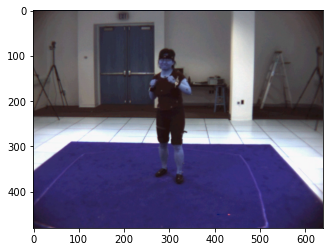

In [58]:
# import cv2 
from matplotlib import pyplot as plt

myFrameNumber =6
cap = cv2.VideoCapture("../Dataset/HumanEva-I/S1/Image_Data/Box_1_(C1).avi")

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("Total Frames: ", totalFrames)
# check for valid frame number
if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber-1)

while True:
    ret, frame = cap.read()
    plt.imshow(frame)
    plt.show() 
    break



Total Frames:  28962.0


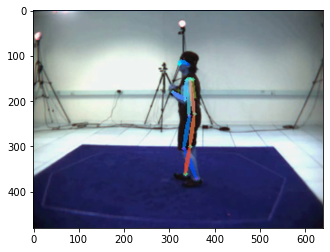

In [1]:
import cv2 
from matplotlib import pyplot as plt

myFrameNumber = 81
cap = cv2.VideoCapture("AlphaPose_all.avi")

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("Total Frames: ", totalFrames)
# check for valid frame number
if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber)

while True:
    ret, frame = cap.read()
    plt.imshow(frame)
    plt.show() 
    break



## Load Dictionary of frame used

How to get dictionary? <br>
You can run 

file:///media/ivan/Ivan/Project%20Lab/THESIS_FALL_DETECTION/2D%20to%203D%20Pose/VideoPose3D-master/data/prepare_data_humaneva.py

It will produce NPY and frame together

In [3]:
import pickle
from glob import glob

a_file = open("../Dataset/HumanEva-I/converted_15j/used_frame.pkl", "rb")
frame_used = pickle.load(a_file)
print(frame_used)

{'S1': {'Box 1': [(395, 423, True, 'Train', 'Box 1 chunk1'), (437, 475, True, 'Train', 'Box 1 chunk3'), (500, 585, True, 'Train', 'Box 1 chunk5'), (692, 789, True, 'Train', 'Box 1 chunk7'), (5, 36, True, 'Validate', 'Box 1 chunk0'), (49, 181, True, 'Validate', 'Box 1 chunk2'), (213, 293, True, 'Validate', 'Box 1 chunk4'), (352, 358, True, 'Validate', 'Box 1 chunk6')], 'Gestures 1': [(395, 801, True, 'Train', 'Gestures 1 chunk0'), (5, 395, True, 'Validate', 'Gestures 1 chunk0')], 'Jog 1': [(601, 691, True, 'Train', 'Jog 1 chunk1'), (713, 740, True, 'Train', 'Jog 1 chunk3'), (5, 239, True, 'Validate', 'Jog 1 chunk0'), (270, 286, True, 'Validate', 'Jog 1 chunk2'), (297, 364, True, 'Validate', 'Jog 1 chunk4')], 'ThrowCatch 1': [(712, 929, True, 'Train', 'ThrowCatch 1 chunk1')], 'Walking 1': [(590, 1203, True, 'Train', 'Walking 1 chunk0'), (5, 18, True, 'Validate', 'Walking 1 chunk0'), (34, 193, True, 'Validate', 'Walking 1 chunk2'), (204, 590, True, 'Validate', 'Walking 1 chunk4')]}, 'S2':

In [4]:
frame_used

{'S1': {'Box 1': [(395, 423, True, 'Train', 'Box 1 chunk1'),
   (437, 475, True, 'Train', 'Box 1 chunk3'),
   (500, 585, True, 'Train', 'Box 1 chunk5'),
   (692, 789, True, 'Train', 'Box 1 chunk7'),
   (5, 36, True, 'Validate', 'Box 1 chunk0'),
   (49, 181, True, 'Validate', 'Box 1 chunk2'),
   (213, 293, True, 'Validate', 'Box 1 chunk4'),
   (352, 358, True, 'Validate', 'Box 1 chunk6')],
  'Gestures 1': [(395, 801, True, 'Train', 'Gestures 1 chunk0'),
   (5, 395, True, 'Validate', 'Gestures 1 chunk0')],
  'Jog 1': [(601, 691, True, 'Train', 'Jog 1 chunk1'),
   (713, 740, True, 'Train', 'Jog 1 chunk3'),
   (5, 239, True, 'Validate', 'Jog 1 chunk0'),
   (270, 286, True, 'Validate', 'Jog 1 chunk2'),
   (297, 364, True, 'Validate', 'Jog 1 chunk4')],
  'ThrowCatch 1': [(712, 929, True, 'Train', 'ThrowCatch 1 chunk1')],
  'Walking 1': [(590, 1203, True, 'Train', 'Walking 1 chunk0'),
   (5, 18, True, 'Validate', 'Walking 1 chunk0'),
   (34, 193, True, 'Validate', 'Walking 1 chunk2'),
   (204

## Utils to Create Video

In [7]:
##Load Human Eva Video only using frames in dictionary and create a video for alpha pose
video_path="../Dataset/HumanEva-I"
fourcc = 0x7634706d
result = cv2.VideoWriter('all.avi',
                         fourcc,
                         60.07, (640,480))

for index,subject in enumerate(frame_used.keys()):
    for action in frame_used[subject]:
        for chunk in frame_used[subject][action]:
            print("\nSubject: ", subject)
            print ("Frame :", chunk[:2])
            action_ = action.replace(" ","_")
            print("Action : ", action)

            for a in range(1,4):
                path = video_path + '/' + subject + '/Image_Data'+'/'+action_+"_(C"+str(a)+").avi"
                cap = cv2.VideoCapture(path)
                print("Video Path :",path)
                totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                print("Total Frames: ", totalFrames)

                #Load video according frames in dictionary
                for frame_index in  range(chunk[0],chunk[1]+1):
                    # check for valid frame number
                    if frame_index >= 0 & frame_index <= totalFrames:
                        # set frame position
                        cap.set(cv2.CAP_PROP_POS_FRAMES,frame_index-1)
                    while True:
                        ret, frame = cap.read()
                        result.write(frame)
                        break
                    print (frame_index)
result.release()
print("The video was successfully saved")



Subject:  S1
Frame : (395, 423)
Action :  Box 1
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Box_1_(C1).avi
Total Frames:  863.0
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Box_1_(C2).avi
Total Frames:  863.0
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Box_1_(C3).avi
Total Frames:  863.0
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423

Subject:  S1
Frame : (437, 475)
Action :  Box 1
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Box_1_(C1).avi
Total Frames:  863.0
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Box_1_(C2

354
355
356
357
358

Subject:  S1
Frame : (395, 801)
Action :  Gestures 1
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Gestures_1_(C1).avi
Total Frames:  872.0
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603


350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Gestures_1_(C3).avi
Total Frames:  872.0
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
21

361
362
363
364

Subject:  S1
Frame : (712, 929)
Action :  ThrowCatch 1
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/ThrowCatch_1_(C1).avi
Total Frames:  1052.0
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920

1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Walking_1_(C3).avi
Total Frames:  1315.0
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
73

422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
Video Path : ../Dataset/HumanEva-I/S1/Image_Data/Walking_1_(C3).avi
Total Frames:  1315.0
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
26

105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176

Subject:  S2
Frame : (189, 192)
Action :  Box 1
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Box_1_(C1).avi
Total Frames:  916.0
189
190
191
192
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Box_1_(C2).avi
Total Frames:  915.0
189
190
191
192
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Box_1_(C3).avi
Total Frames:  916.0
189
190
191
192

Subject:  S2
Frame : (236, 296)
Action :  Box 1
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Box_1_(C1).avi
Total Frames:  916.0
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
29

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Gestures_1_(C3).avi
Total Frames:  1052.0
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111

Subject:  S2
Frame : (123, 129)
Action :  Gestures 1
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Gestures_1_(C1).avi
Total Frames:  1052.0
123
124
125
126
127
128
129
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Gestures_1_(C2).avi
Total Frames:  1052.0
123
124
125
126
127
128
129
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Gestures_1_(C3).avi
Total Frames:  1052.0
123
124
125
126
127
128
129

Subject:  S2
Frame : (164, 375)
Act

582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/Jog_1_(C3).avi
Total Frames:  952.0
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412

657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/ThrowCatch_1_(C2).avi
Total Frames:  1256.0
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/ThrowCatch_1_(C3).avi
Total Frames:  1256.0
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
63

123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226

Subject:  S2
Frame : (241, 279)
Action :  ThrowCatch 1
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/ThrowCatch_1_(C1).avi
Total Frames:  1256.0
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
Video Path : ../Dataset/HumanEva-I/S2/Image_Data/ThrowCatch_1_(C2).avi
Total Frames:  1256.0
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
Video Path : ../Dataset/HumanE

459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708


513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762


273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
Video Path : ../Dataset/HumanEva-I/S3/Im

311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
Video Path : ../Dataset/HumanEva-I/S3/Image_Data/Gestures_1_(C3).avi
Total Frames:  1200.0
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346

Subject:  S3
Frame : (401, 754)
Action :  Jog 1
Video Path : ../Dataset/HumanEva-I/S3/Image_Data/Jog_1_(C1).avi
Total Frames:  908.0
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522

110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359


923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
Video Path : ../Dataset/HumanEva-I/S3/Image_Data/Walking_1_(C2).avi
Total Frames:  1020.0
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
Video Path : ../Dataset/HumanEva-I/S3/Image_Data/Walking_1_(C3).avi
Total Frames:  1020.0
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939

Subject:  S3
Frame : (5, 95)
Action :  Walking 1
Video Path : .

# Load Human3.6M Skeleton (CDF Files)

In [2]:

import copy
import glob
import os

import cdflib
import numpy as np

In [3]:
cdf_file = cdflib.CDF("../Dataset/Human3.6m/data/h36m/S1/MyPoseFeatures/D3_Positions/Discussion 1.cdf")

In [4]:
poses = cdf_file.varget("Pose").squeeze()

In [5]:
poses.shape

(3805, 96)

Total Frames:  3809.0


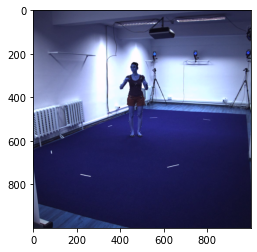

In [6]:
import cv2 
from matplotlib import pyplot as plt

myFrameNumber = 81
cap = cv2.VideoCapture("../Dataset/Human3.6m/Videos/S1/Videos/Discussion 1.55011271.mp4")

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("Total Frames: ", totalFrames)
# check for valid frame number
if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber)

while True:
    ret, frame = cap.read()
    plt.imshow(frame)
    plt.show() 
    break

In [8]:
import torch

train_2d_file = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/train_2d.pth.tar'
train_3d_file = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/train_3d.pth.tar'
train_2d = torch.load(train_2d_file)
train_3d = torch.load(train_3d_file)

In [80]:
train_2d.keys()

dict_keys([(1, 'Directions', 'Directions 1.54138969.h5'), (1, 'Directions', 'Directions 1.55011271.h5'), (1, 'Directions', 'Directions 1.58860488.h5'), (1, 'Directions', 'Directions 1.60457274.h5'), (1, 'Directions', 'Directions.54138969.h5'), (1, 'Directions', 'Directions.55011271.h5'), (1, 'Directions', 'Directions.58860488.h5'), (1, 'Directions', 'Directions.60457274.h5'), (1, 'Discussion', 'Discussion 1.54138969.h5'), (1, 'Discussion', 'Discussion 1.55011271.h5'), (1, 'Discussion', 'Discussion 1.58860488.h5'), (1, 'Discussion', 'Discussion 1.60457274.h5'), (1, 'Discussion', 'Discussion.54138969.h5'), (1, 'Discussion', 'Discussion.55011271.h5'), (1, 'Discussion', 'Discussion.58860488.h5'), (1, 'Discussion', 'Discussion.60457274.h5'), (1, 'Eating', 'Eating 2.54138969.h5'), (1, 'Eating', 'Eating 2.55011271.h5'), (1, 'Eating', 'Eating 2.58860488.h5'), (1, 'Eating', 'Eating 2.60457274.h5'), (1, 'Eating', 'Eating.54138969.h5'), (1, 'Eating', 'Eating.55011271.h5'), (1, 'Eating', 'Eating.5

In [19]:
train_2d[(1, 'Directions', 'Directions 1.54138969.h5')]

array([[-0.54206337,  0.39774939, -0.25891828, ...,  0.50499701,
        -0.13092847,  0.84361908],
       [-0.54202631,  0.3979099 , -0.25901394, ...,  0.50466484,
        -0.13451224,  0.84106828],
       [-0.54197441,  0.39812588, -0.25907457, ...,  0.50429103,
        -0.13675047,  0.83949435],
       ...,
       [-0.21510374,  0.25639036, -0.00093129, ...,  0.39066466,
         0.14141714,  0.77535449],
       [-0.21488717,  0.25643375, -0.00097459, ...,  0.39190025,
         0.13565916,  0.77486517],
       [-0.21475918,  0.25628491, -0.00116293, ...,  0.39290413,
         0.12924942,  0.77524044]])

In [13]:
train_3d[(1, 'Directions', 'Directions 1.54138969.h5')].shape

(1383, 48)